In [33]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,684427,36.6,2347261,125.4,3667594,195.9
Vcells,46645378,355.9,209769632,1600.5,284348132,2169.5


In [34]:

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "~/buckets/b1/datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "paquete_premium_202011.csv")

#Archivo con datos sin etiquetar para generar la predicción
karchivo_predecir      <-  paste0(kcarpeta_datasets, "paquete_premium_202101.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  48750

#Pérdida por FP
kFPGain               <-  -1250

#Establezco semilla aleatoria
set.seed(1)



In [35]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

In [36]:
#Genero la clase
dataset[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
dataset[ ,  (kcampos_a_borrar) := NULL    ] 

#Completo missings
dataset[is.na(dataset)] <- 0

Warning message in `[.data.table`(dataset, , ..kclase_nomcampo):
“Both 'kclase_nomcampo' and '..kclase_nomcampo' exist in calling scope. Please remove the '..kclase_nomcampo' variable in calling scope for clarity.”


In [37]:
# generacion del modelo
formula  <-  formula(paste(kobjetivo, "~ ."))

[1] 2.108366


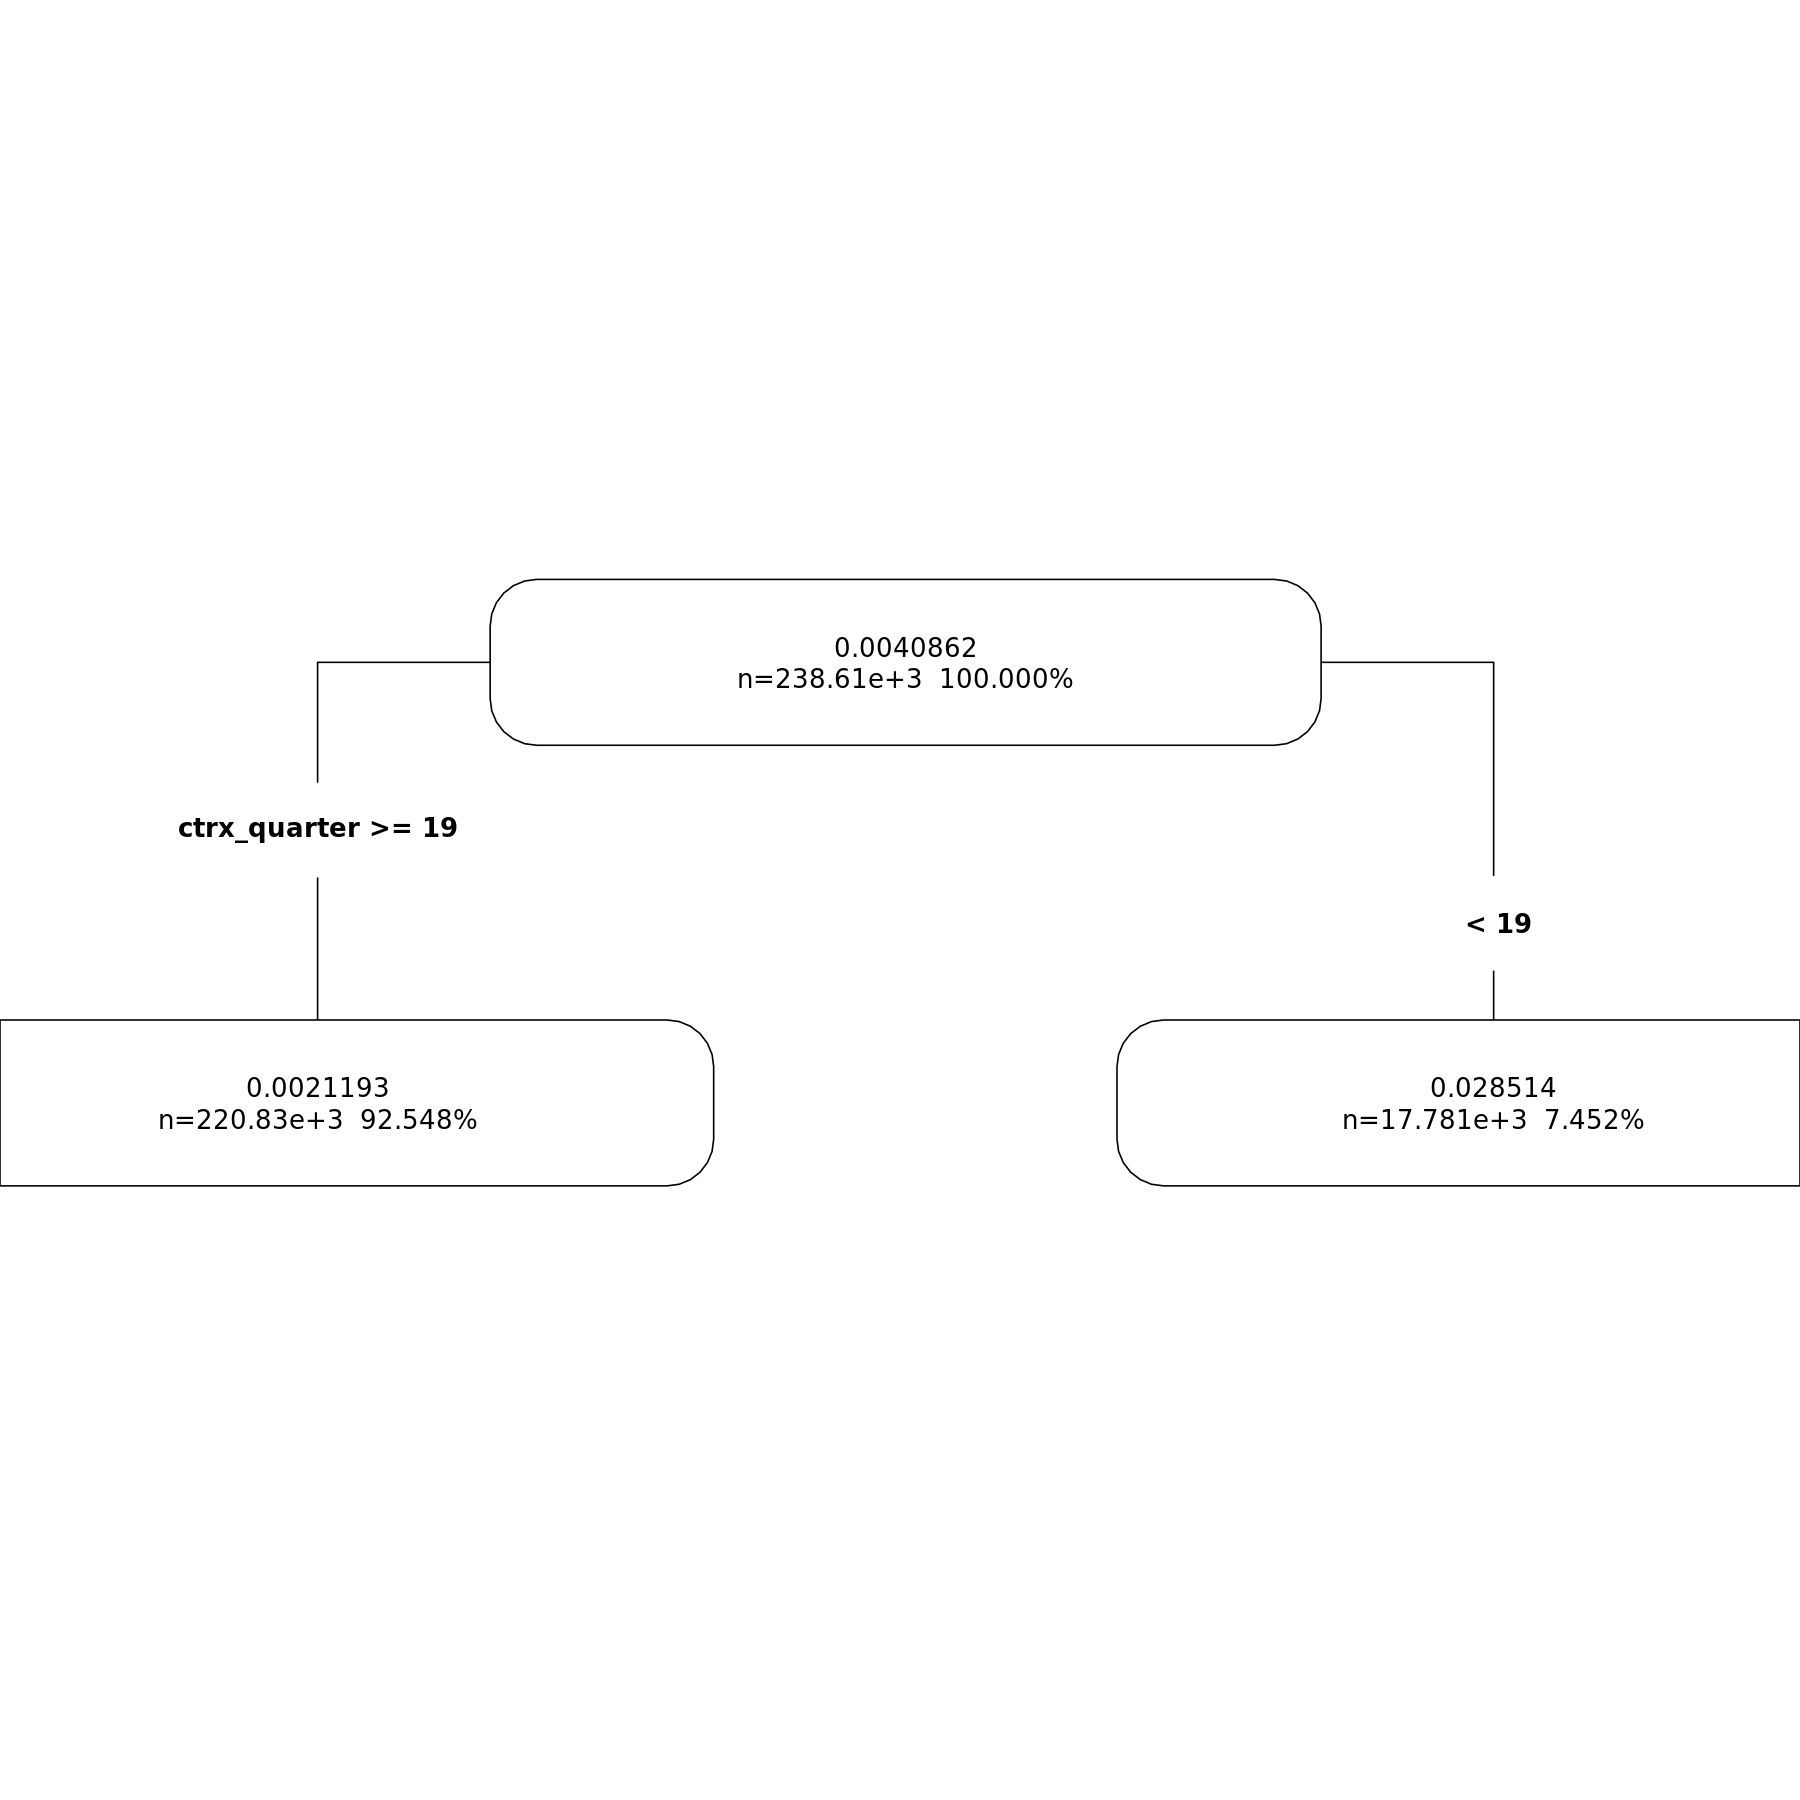

In [38]:
#Genero el modelo sobre dataset completo

t0       <-  Sys.time()
modelo   <-  rpart(formula,   data = dataset,  maxdepth=1, cp = 0, xval = 0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [39]:
modelo

n= 238608 

node), split, n, deviance, yval
      * denotes terminal node

1) root 238608 971.0160 0.004086200  
  2) ctrx_quarter>=18.5 220827 467.0082 0.002119306 *
  3) ctrx_quarter< 18.5 17781 492.5436 0.028513580 *

In [40]:
#Leo datos a estimar
dataset_pred <- fread(karchivo_predecir)


#Genero la clase
#dataset_pred[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
#dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 

prediccion  <- predict( modelo, dataset_pred ) #aplico el modelo

In [41]:
dataset_pred[ , prob_baja := prediccion]
dataset_pred[ , Predicted  := as.numeric(prob_baja > 0.025) ]

entrega  <- dataset_pred[   , list(numero_de_cliente, Predicted) ] #genero la salida

#genero el archivo para Kaggle
fwrite( entrega, file="./salida_rpart_maxdepth.csv", sep="," )